In [1]:
%matplotlib inline
import os

import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVL"] = "3"

tf.random.set_seed(43)

## Load Data: 

In [2]:
train = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
train.sample(10)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
544,0,male,18.0,0,0,7.7500,Third,unknown,Southampton,y
293,1,male,3.0,1,1,18.7500,Second,unknown,Southampton,n
596,0,male,28.0,8,2,69.5500,Third,unknown,Southampton,n
132,0,female,28.0,8,2,69.5500,Third,unknown,Southampton,n
246,0,male,28.0,0,0,13.0000,Second,unknown,Southampton,y
490,1,male,31.0,1,0,57.0000,First,B,Southampton,n
154,1,male,40.0,0,0,31.0000,First,A,Cherbourg,y
126,0,male,4.0,4,1,29.1250,Third,unknown,Queenstown,n
541,0,male,32.0,0,0,8.3625,Third,unknown,Southampton,y
163,0,male,51.0,0,0,8.0500,Third,unknown,Southampton,y


In [3]:
train.isna().sum()

survived              0
sex                   0
age                   0
n_siblings_spouses    0
parch                 0
fare                  0
class                 0
deck                  0
embark_town           0
alone                 0
dtype: int64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB


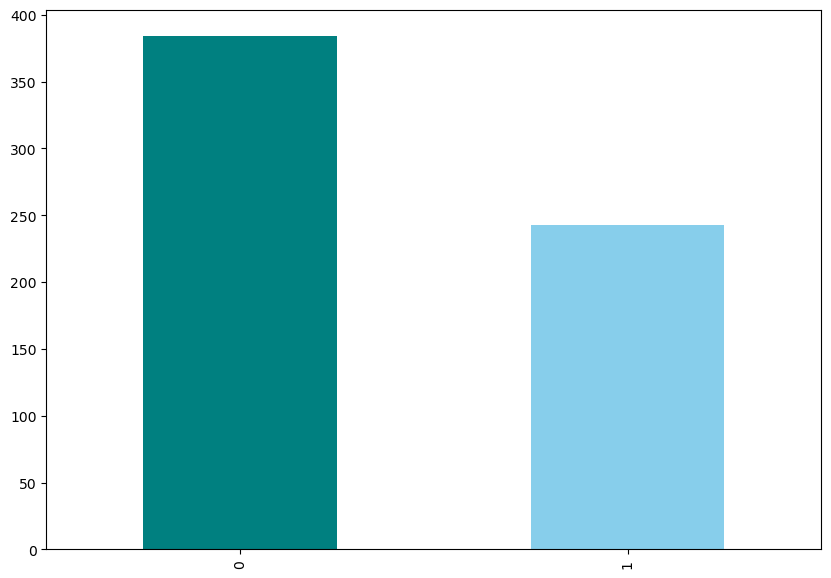

In [5]:
train.survived.value_counts().plot.bar(color = ['teal', 'skyblue'], figsize = (10, 7));

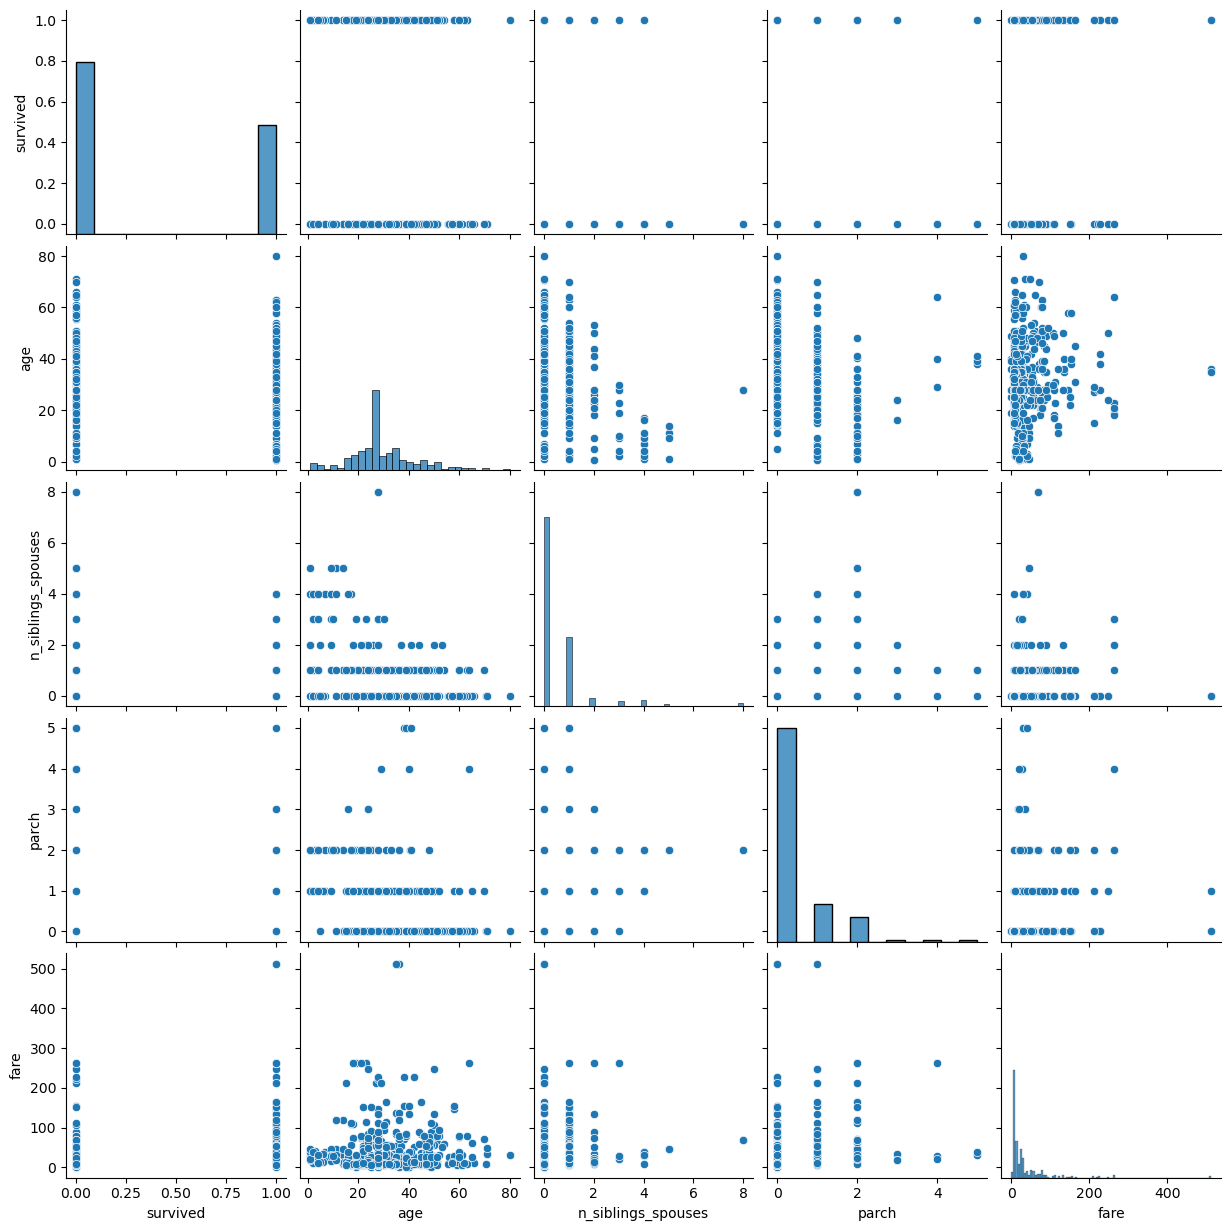

In [6]:
sns.pairplot(train);

In [7]:
titanic_label = train.pop("survived")
titanic_features = train.copy()

titanic_features.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


## Fead this csv data into Tensorflow.

- 1. Create tensorflow-keras input symboic object.

In [8]:
input = tf.keras.Input(shape=(), dtype=tf.float32)

In [9]:
inputs = {}
for name, col in titanic_features.items():
    dtype = col.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'sex': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'n_siblings_spouses': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 'parch': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 'fare': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 'class': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 'deck': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 'embark_town': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 'alone': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>}

In [10]:
# -- get and normalize numerical inputs.
numeric_inputs = { name: input for name, input in inputs.items() if input.dtype==tf.float32 }

x = tf.keras.layers.Concatenate()(list(numeric_inputs.values()))
normalize = tf.keras.layers.Normalization()
normalize.adapt(np.array(titanic_features[numeric_inputs.keys()]))
all_numeric_inputs = normalize(x)

all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization')>

In [11]:
# -- Collect all the symbolic preprocessing results, to concatenate them later:
preprocessed_inputs = [all_numeric_inputs]

In [12]:
# -- normalize string inputs: One-Hot encoding.
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    lookup = tf.keras.layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
    one_hot = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

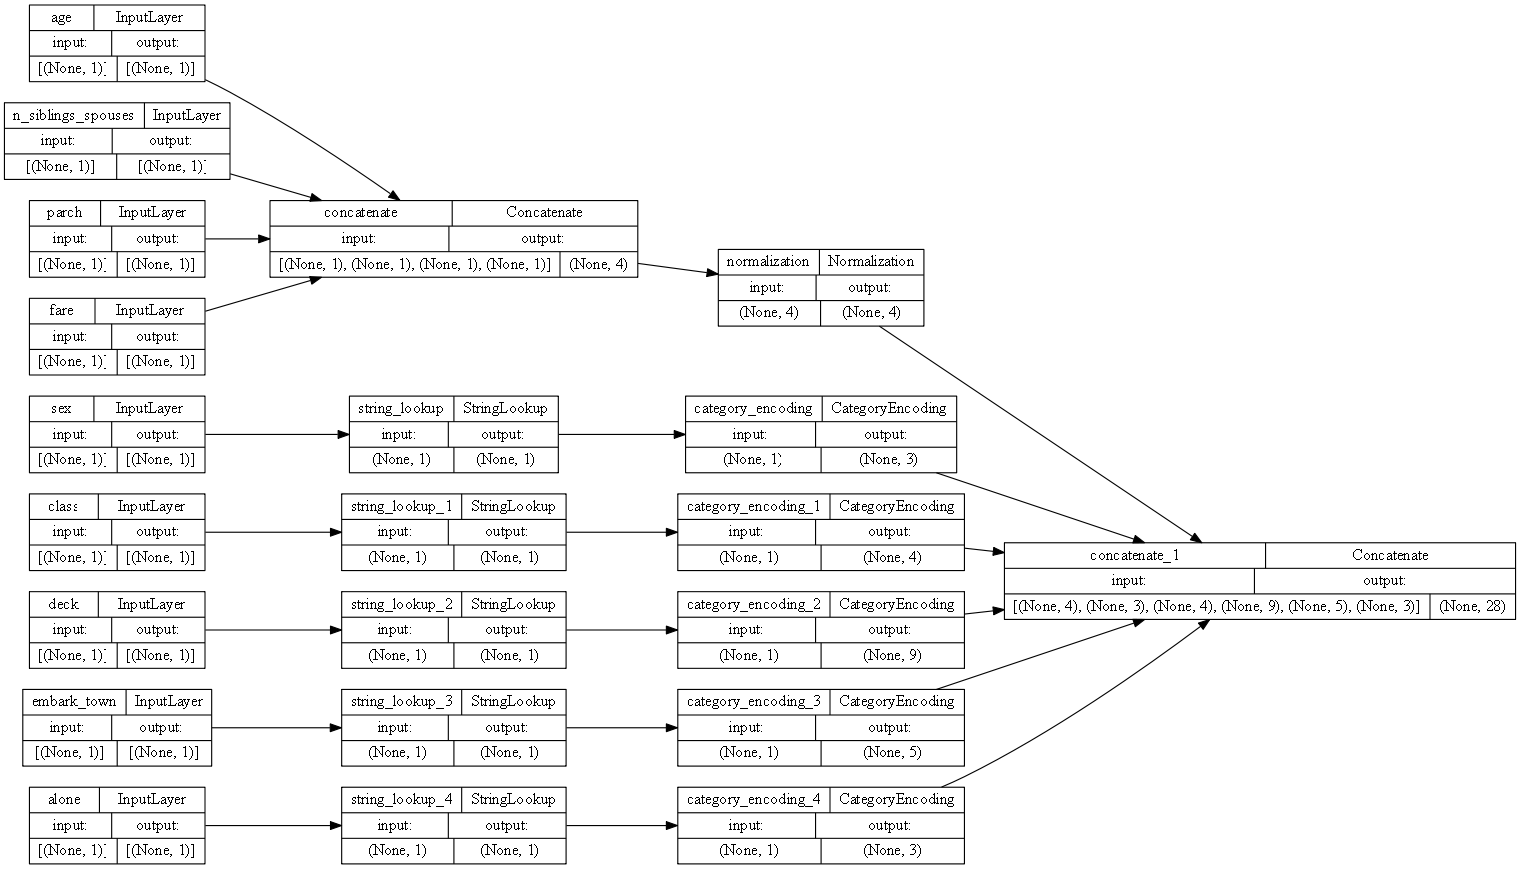

In [13]:
preprocessed_inputs_cat = tf.keras.layers.Concatenate()(preprocessed_inputs)
titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)
tf.keras.utils.plot_model(model = titanic_preprocessing, rankdir='LR', dpi=80, show_shapes=True)

## Convert the all data into dictionary of tensors for the model.

In [14]:
titanic_featues_dict = { name: np.array(value) for name, value in titanic_features.items() }

In [15]:
# -- test out first training example, pass it to the preprocessing model. 
feat_dict = { name: values[:1] for name, values in titanic_featues_dict.items() }

titanic_preprocessing(feat_dict)

<tf.Tensor: shape=(1, 28), dtype=float32, numpy=
array([[-0.610415 ,  0.395198 , -0.4790527, -0.4974028,  0.       ,
         0.       ,  1.       ,  0.       ,  0.       ,  0.       ,
         1.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  1.       ,
         0.       ,  0.       ,  0.       ,  1.       ,  0.       ,
         0.       ,  1.       ,  0.       ]], dtype=float32)>

## Build the model:

In [16]:
def titanic_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        tf.keras.layers.Dense(32),
        tf.keras.layers.Dropout(.2),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(16),
        tf.keras.layers.Dense(1),
    ])

    preprocessed_inputs = preprocessing_head(inputs)
    result = body(preprocessed_inputs)
    model = tf.keras.Model(inputs, result)

    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam()
    )
    return model


titanic_model = titanic_model(titanic_preprocessing, inputs)

In [17]:
titanic_model.fit(x = titanic_featues_dict, y = titanic_label, epochs = 20)

Epoch 1/20
20/20 [==============================] - 1s 5ms/step - loss: 0.7014
Epoch 2/20
20/20 [==============================] - 0s 5ms/step - loss: 0.5283
Epoch 3/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4812
Epoch 4/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4552
Epoch 5/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4343
Epoch 6/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4415
Epoch 7/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4370
Epoch 8/20
20/20 [==============================] - 0s 7ms/step - loss: 0.4475
Epoch 9/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4308
Epoch 10/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4214
Epoch 11/20
20/20 [==============================] - 0s 6ms/step - loss: 0.4381
Epoch 12/20
20/20 [==============================] - 0s 6ms/step - loss: 0.4292
Epoch 13/20
20/20 [==============================

In [ ]:
# titanic_model.save("titanic_test")